# Binary Classifier v2.0

Date last updated: 25/07/18 <br>
Author: John Lingi

This is a script to create a simple binary classifier for discriminating between two emotional styles of text. In this instance, we look at sentences which convey happiness and anger.

Changes from 1.0:
1. Shortened length of input sequence
2. Reduced complexity by switching from a Bi-directional LSTM to a standard LSTM
3. Longer training

Current dir: /homes/jl1809/Documents/thesis/src/model/binary_classifier
Parent dir: /homes/jl1809/Documents/thesis/src/model
Source dir: /homes/jl1809/Documents/thesis/src
Did you check the root data path?
Loading training data from anger/joy datasets
Loading data from /homes/jl1809/Documents/thesis/src/data/semeval18/processed/anger-train-processed.txt
Loading data from /homes/jl1809/Documents/thesis/src/data/semeval18/processed/joy-train-processed.txt
Loaded 1639 tweets.
Loading training data from anger/joy datasets
Loading data from /homes/jl1809/Documents/thesis/src/data/semeval18/processed/anger-val-processed.txt
Loading data from /homes/jl1809/Documents/thesis/src/data/semeval18/processed/joy-val-processed.txt
Loaded 288 tweets.
Num training: 1639 	Num validation: 288
N class 0: 705 	N class 1: 934


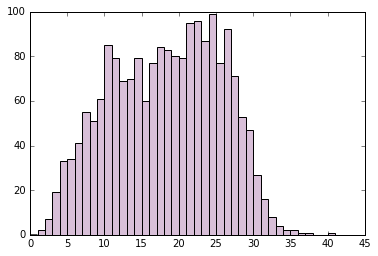

Using TensorFlow backend.



MAX SEQUENCE LENGTH: 41
Removing sentences that are greater than 41 tokens in length
Removed 0 data points
Removed 0 data points
Num training: 1639 	Num validation: 288


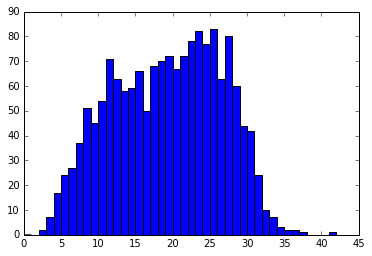

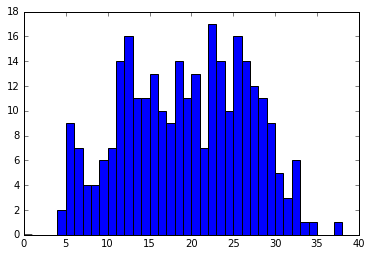

Did you check the vocabulary path?
Loaded vocabulary of size 13105
X train input shape (1639, 42, 13105)
X val input shape (288, 42, 13105)
y train input shape (1639,)
y val input shape (288,)


In [1]:
%run Data_preparation.ipynb

In [2]:
import keras
print("[+] Using Keras version", keras.__version__)

[+] Using Keras version 2.2.0


## Model

#### Definition

In [3]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, Bidirectional, Conv1D, MaxPool1D, Flatten, Dropout, Input

Try a simple classifier first

In [4]:
def build_model(latent_dim, vocab_size, dropout=0, lstm_layers = 1, max_sequence_length=MAX_SEQUENCE_LENGTH):
    
    model = Sequential()
#     model_inputs = Input(shape=(None, vocab_size))
#     x = Bidirectional(LSTM(latent_dim, name="bilstm_0"))(model_inputs)
#     x, _, _ = LSTM(latent_dim, name="lstm_0", dropout=0, return_sequences=True)(model_inputs)
#     x = LSTM(latent_dim, name="lstm_1", dropout=0)(x)
#     x = Dropout(latent_dim)(x)
#     model_output = (Dense(1, activation="sigmoid", name="sigmoid_classifier"))(x)
#     model = Model(inputs=model_inputs, outputs=model_output)
    
    if lstm_layers == 1:
        model.add(LSTM(latent_dim, input_shape=(max_sequence_length, vocab_size)))
    else:
        model.add(LSTM(latent_dim, return_sequences=True, input_shape=(max_sequence_length, vocab_size)))
        for i in range(lstm_layers - 1):
            model.add(LSTM(latent_dim))
        
    model.add(Dropout(dropout))
    model.add(Dense(1, activation="sigmoid"))
    
    return model

#### Train

In [5]:
def train(model, x_train, y_train, x_val, y_val, batch_size=32, epochs=20, optimizer="adam", loss="binary_crossentropy", callbacks=None):
    # sparse inputs, adadelta or similar like RMSprop is preferred
    model.compile(optimizer=optimizer, loss=loss, metrics=["acc"])
    
    # Define callbacks
    if callbacks is None:
        callback_list = []
    else: 
        callback_list = callbacks

    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), 
          batch_size=batch_size, epochs=epochs,
          callbacks=callback_list)

    return history

#### Predict

In [6]:
def predict(models, x_test):
    """
    model can be a list of models or a single model. If it's a list then a list of N predictions will be returned,
    where N is the number of models
    """
    
    if type(models) != list:
        preds = np.where(models.predict(x_test) <= 0.5, 0, 1)
    
    else:
        preds = []
        for model in models:
            single_prediction = np.where(model.predict(x_test) <= 0.5, 0, 1)
            preds.append(single_prediction)

    return preds

#### Cross-validation

We define a cross validation function to be used if desired

In [7]:
from sklearn.model_selection import StratifiedKFold

In [33]:
def cross_val(x, y, latent_dim, vocab_size, max_sequence_length, dropout, folds=5, batch_size=32, epochs=50, callbacks=None):
    skf = StratifiedKFold(n_splits=folds)
    trained_models = []
    fold_counter = 0
    
    x, y = shuffle(x, y)
    
    for train_index, val_index in skf.split(x, y):
        # print("TRAIN:", train_index, "TEST:", val_index)
        print("Training for fold", fold_counter)
        x_train, x_val = x[train_index], x[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model = build_model(latent_dim, vocab_size, dropout, 2, max_sequence_length)

        # Define callbacks
        if callbacks is None:
            callback_list = []
        else: 
            callback_list = callbacks
        
        train(model, x_train, y_train, x_val, y_val, batch_size, epochs, callbacks=callback_list)

        trained_models.append(model)
        fold_counter += 1

        return trained_models
        
    return trained_models
    

### Run training

#### Callbacks

In [9]:
from keras import callbacks

In [10]:
# model_checkpoints = callbacks.ModelCheckpoint("k-fold-benchmark-checkpoint-{val_loss:.3f}.h5", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=0)
early_stopping = callbacks.EarlyStopping(min_delta=0, patience=4, monitor="val_acc", mode="max")
# model_checkpoints = callbacks.ModelCheckpoint("lstm-binary-classifier-{val_acc:.3f}.h5", monitor='val_acc', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=0)
callback_list = [early_stopping]

#### Training

In [32]:
# Params
batch_size = 32
epochs = 40
latent_dim = 40
dropout = 0.2

In [12]:
# # Gather data for cross-val
# all_train = np.concatenate((one_hot_train, one_hot_val), axis=0)
# all_labels = np.array(y_train + y_val)
# print(all_train.shape, all_labels.shape)

In [13]:
model = build_model(latent_dim, vocab_size=vocab_size, dropout=dropout, lstm_layers=1, max_sequence_length=(MAX_SEQUENCE_LENGTH + 1))

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 40)                2103360   
_________________________________________________________________
dropout_4 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 41        
Total params: 2,103,401
Trainable params: 2,103,401
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = train(model, x_train, y_train, 
                x_val, y_val, 
                batch_size=batch_size, epochs=epochs, 
                optimizer="adam", callbacks=callback_list)

Train on 1639 samples, validate on 288 samples
Epoch 1/40
1639/1639 [==============================] - 28s 17ms/step - loss: 0.6852 - acc: 0.5686 - val_loss: 0.7025 - val_acc: 0.5139
Epoch 2/40
1639/1639 [==============================] - 9s 5ms/step - loss: 0.5274 - acc: 0.7145 - val_loss: 0.5710 - val_acc: 0.7812
Epoch 3/40
1280/1639 [======================>.......] - ETA: 1s - loss: 0.1333 - acc: 0.9750

KeyboardInterrupt: 

### Cross val training

In [34]:
xcv = np.concatenate((x_train, x_val), axis=0) 
ycv = np.concatenate((y_train, y_val), axis=0)

In [35]:
xcv.shape, ycv.shape

((1927, 42, 13105), (1927,))

In [ ]:
models = cross_val(xcv, ycv, latent_dim, vocab_size, MAX_SEQUENCE_LENGTH + 1, dropout, callbacks=callback_list, 
                   batch_size=batch_size, epochs=epochs)

Training for fold 0
Train on 1541 samples, validate on 386 samples
Epoch 1/40
1541/1541 [==============================] - 15s 10ms/step - loss: 0.6880 - acc: 0.5483 - val_loss: 0.6842 - val_acc: 0.5622
Epoch 2/40
1541/1541 [==============================] - 12s 8ms/step - loss: 0.4756 - acc: 0.7450 - val_loss: 0.2686 - val_acc: 0.8627
Epoch 3/40
1541/1541 [==============================] - 12s 8ms/step - loss: 0.0696 - acc: 0.9831 - val_loss: 0.1177 - val_acc: 0.9482
Epoch 4/40
1541/1541 [==============================] - 12s 8ms/step - loss: 0.0261 - acc: 0.9922 - val_loss: 0.2630 - val_acc: 0.9249
Epoch 5/40
1541/1541 [==============================] - 12s 8ms/step - loss: 0.0093 - acc: 0.9974 - val_loss: 0.1301 - val_acc: 0.9482
Epoch 6/40
1541/1541 [==============================] - 12s 8ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.1714 - val_acc: 0.9508
Epoch 7/40
1541/1541 [==============================] - 12s 8ms/step - loss: 9.6273e-04 - acc: 1.0000 - val_loss: 0.1841 -

#### Plot

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs_axis = range(1, len(acc) + 1)

plt.plot(epochs_axis, acc, 'b', label="Training Accuracy")
plt.plot(epochs_axis, val_acc, 'r', label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Binary classifier training" + " dropout: " + str(dropout) + " latent dims: " + str(latent_dim))
# plt.savefig(current_dir + '/10_tokens/figures/binclass-bilstm-dense-' + str(latent_dim) + 'hdim-'
#             + str(dropout) + 'drop.png', bbox_inches='tight')

In [19]:
# Small tests on this basic model
x_test_2 = ["excited am so angry <eos>",
            "today is a great day <eos>",            
            "that lady pisses me off <eos>",
            "fantastic , fantastic , fantastic <eos>",
            "why can not doctors just do their job properly ? <eos>",
            "i love m dada <eos>",
            "you look angry . <eos>",
            "we are all one big , happy family here . <eos>",
            "i was glad the movie had a happy ending . <eos>",
            "i am not happy with you . <eos>",
            "you are the best man <eos>",
            "i am so blessed <eos>",
            "i am happy happy <eos>",
            "i am happy <eos>",
            "very angry right now <eos>",
            "<user> lovely being home after spending some christmas overseas <laugh> <eos>",
            "<user> happy birthday keevie <eos>",
            "<user> happy new year girls las amo <happy> xx <eos>",
            "makes me so happy living my dream <eos>",
            "not been a good day at all ! <eos>",
            "<user> i hate this <curse> show ! hahaha <eos>",
            "sunflowers for in the . me . me to much happy"
         ]
          
x_test_2 = one_hot_data(x_test_2, word2id, MAX_SEQUENCE_LENGTH + 1)
y_test_2 = [1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0]

In [ ]:
model.predict(x_test_2)

In [ ]:
y_preds = predict(model, x_test_2).squeeze()
y_preds

In [21]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_test_2, y_preds)

In [ ]:
max_val_acc = max(model.history.history["val_acc"])

In [ ]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

### Cross val test

In [26]:
def get_best_model(models, x_test, y_test):
    best_model = 0
    best_score = 0

    preds = predict(models, x_test)
    
    for i, pred in enumerate(preds):
        acc = accuracy_score(y_test, pred)
        print("Model", i, "accuracy:", acc)
        if acc > best_score:
            best_model = models[i]
            best_score = acc
        
    return best_model, best_score

In [28]:
best_model, best_score = get_best_model(models, x_test_2, y_test_2)

Model 0 accuracy: 0.8636363636363636


In [29]:
best_score

0.8636363636363636

In [73]:
y_preds_2 = predict(best_model, x_test_2)

In [74]:
y_preds_2.squeeze().tolist()

[1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0]

In [75]:
y_test_2

[1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0]

In [76]:
accuracy_score(y_test_2, y_preds_2)

0.9545454545454546

#### Save

In [17]:
name = ("{0}/10_tokens/binclassifier-lstm-dense-10tokens-{1}vocab-{2}drop-{3}latentdim-{4:.3f}valacc").format(
    current_dir, vocab_size, dropout, latent_dim, 0.9585)

# print(name)
models[0].save(name + ".h5")
models[0].save_weights(name + "-weights.h5")